<a href="https://colab.research.google.com/github/Abdelrhman-Sayed70/Game_Application_Success_Prediction/blob/main/Game_Success_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from statistics import mean

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 
# Read Data

In [44]:
df = pd.read_csv('games-regression-dataset.csv')

In [45]:
df.shape

(5214, 18)

# 
# Functions

**`PreprocessListCategories`** <br>
`Function take df, list of categories columns and apply OHE on them, then return the df after modifications`

In [46]:
def PreprocessListCategories(df, lst):
    for col in lst:
        # Apply one-hot encoding to the "col" column in list and put the output in newdf
        newdf = df[col].str.get_dummies(sep=', ')
        
        # Concatenate the one-hot encoded columns with the original DataFrame
        df = pd.concat([df, newdf], axis=1)
        
    return df

**`CheckNullRows`**<br>
`Function take df and print number of null rows`

In [47]:
def CheckNullRows(df):
    missing_rows = df.isnull().any(axis=1).sum()
    print('Number of rows that have null values: ', missing_rows)

**`DropNullRows`**<br>
`Function take df and drop all null rows`

In [48]:
def DropNullRows(df):
    df.dropna(inplace=True)

**`ChangeDataType`**<br>
`Function take df and change data types of some columns to appropriate data type`

In [49]:
def PreProcessAgrRating(df):
    # Age Rating 
    # Print current data type
    print('Data type of Age Rating is, ', df['Age Rating'].dtype)
    # Remove the + sign
    df['Age Rating'] = df['Age Rating'].str.replace('+', '', regex=False)
    # Convert Column datatype to int
    df['Age Rating'] = df['Age Rating'].astype(int)
    print('Data type of Age Rating after processing is ', df['Age Rating'].dtype)
    # Create a dictionary to map the age ratings to integers
    age_rating_map = {4: 1, 9: 2, 12: 3, 17: 4}
    # Replace each value with its category
    df['Age Rating'] = df['Age Rating'].replace(age_rating_map)
    # Print Age Rating
    print(df['Age Rating'].head())

In [50]:
def ConvertToDateTime(df, lst):
    for col in lst:
        df[col] = pd.to_datetime(df[col],dayfirst=True)

In [51]:
def GetColumnsNullsPerc(df):
    # print count of nulls for each column and percentage of them
    missing_data = pd.DataFrame({'total_missing': df.isnull().sum(), 'perc_missing': (df.isnull().mean())*100})
    return missing_data

In [52]:
def CheckListOfCategoriesColumn(df, col):
    print("Data type of ", col, "column is: ", df[col].dtype)
    all_languages = list(set(','.join(df['Languages'].fillna('').unique()).split(',')))
    print(col, "column has ", len(all_languages), "unique", col)

In [53]:
def PrintDfColumns(df):
    columns_list = df.columns.tolist()
    print(columns_list)

In [54]:
def FillColumnNulls(df, col):
    df[col] = df[col].fillna(0)

In [55]:
def DuplicatesDetectionAndRemoval(df):
    print("Number of duplicates rows: ", df.duplicated().sum())
    df.drop_duplicates(inplace = True, keep="first")

In [56]:
def outliers(dataset,col):
    fig, ax =plt.subplots(1,2)
    sns.boxplot( y=col, data=dataset,color="red", ax=ax[0])
    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3-Q1
    lower_bound = Q1-1.5*IQR
    upper_bound = Q3+1.5*IQR
    dataset[col]=dataset[col].apply(lambda x: upper_bound if x> upper_bound else( lower_bound if x< lower_bound  else x))        
    sns.boxplot( y=col, data=dataset,color="blue", ax=ax[1])
    fig.show()

In [57]:
def avarage_Purchases(data,col):
    data[col]=data[col].fillna("0")
    data[col]=data[col].astype(str)
    data[col]=data[col].str.split(",")
    data[col]=[np.float64(x) for x in data[col]]
    data[col]=data[col].apply(lambda x: mean(x))
    data[col]=data[col].astype(float)
    return data

In [58]:
def extract_country(links):
    us_words = []
    for link in links:
        parsed_url = urlparse(link)
        try:
            us_word = parsed_url.path.split('/')[1]
            us_words.append(us_word)
        except IndexError:
            print(f"Malformed link: {link}")
    return us_words

In [59]:
def extract_color(links):
    is_color_list = []
    for link in links:
        parsed_url = urlparse(link)
        netloc = parsed_url.netloc.lower()
        is_color_match = re.search(r"is\d", netloc)
        if is_color_match:
            is_color = is_color_match.group()
        else:
            is_color = None
        is_color_list.append(is_color)
    return is_color_list

In [60]:
def frequent_words_in_name(df):
    # Define the stop words list
    stop_words = set(stopwords.words('english'))
    # Create an empty Counter object to store the word frequencies
    word_freq = Counter()
    # Iterate over each row in the 'Name' column
    for name in df['Name']:
        # Check if the value is a string before tokenizing it
        if isinstance(name, str):
            # Tokenize the name string into words
            words = word_tokenize(name)

            # Filter out stop words and iterate over each word
            for word, pos in nltk.pos_tag(words):
                # Filter out stop words and check if the word is a noun or verb
                if word not in stop_words and (pos.startswith('N') or pos.startswith('V')):
                    # Add the word to the counter
                    word_freq[word.lower()] += 1

    # Get the 50 most frequent words
    most_common_words = [word[0] for word in word_freq.most_common(50)]

    # Replace each word in the 'Name' column with 1 if it matches one of the 50 most frequent words
    df['Name'] = df['Name'].apply(
        lambda x: sum(1 for word in word_tokenize(str(x).lower()) if word in most_common_words) + 1)
    return df

In [61]:
def count_dev_games(df):
  # Create a dictionary to store the frequency of each developer
  developer_freq = df['Developer'].value_counts().to_dict()

  # Replace each developer name with its frequency in the dataset
  df['Developer'] = df['Developer'].map(developer_freq)
  return df

In [62]:
def calc_duration(df):
  # Calculate the difference in years and add 1
  df['Years Since Release'] = (df['Current Version Release Date'].dt.year - df['Original Release Date'].dt.year) + 1 # add 1 for each row because if Years Since Release =0 make it 1 to avoid multipy by 0 in training model
  return df

In [63]:
def price_range(df):
  df["Price"] = df["Price"].dropna().map(lambda x: "Free" if x == 0.00 else("Low Price" if 0.99 <= x <= 4.99 else("Medium Price" if 5.99 <= x <= 19.99 else "High Price")))
  return df

In [64]:
def scaling(df):
  #use Min-Max scaling, which scales the data to a range between 0 and 1.
  # Initialize the MinMaxScaler object
  scaler = MinMaxScaler()
  # Fit and transform the features
  df['User Rating Count'] = scaler.fit_transform(df[['User Rating Count']])
  df['Size'] = scaler.fit_transform(df[['Size']])
  return df

In [65]:
def endcode_price(df):
  age_rating_map = {'Free': 0, 'Low Price': 1,'Medium Price': 2,'High Price': 3}
  df['Price'] = df['Price'].replace(age_rating_map)
  return df

In [66]:
def feature_transformation(df):
    # country name extraction
    df['URL'] = extract_country(df['URL'])
    df.rename(columns = {'URL':'Country'}, inplace = True)
    # color extraction
    df['Icon URL'] = extract_color(df['Icon URL'])
    df.rename(columns = {'Icon URL':'Color'}, inplace = True)
    # price
    df = price_range(df)
    df = endcode_price(df)
    # frequent words in name
    #df = frequent_words_in_name(df)
    #df.rename(columns = {'Name':'frequent words in Name'}, inplace = True)
    # number of other games by dev
    df = count_dev_games(df)
    df.rename(columns = {'Developer':'Other by developer'}, inplace = True)
    # number of languages
    #df['Languages'] = languages_count(df)
    #df.rename(columns = {'Languages':'Languages Count'}, inplace = True)
    # duration between orignal and current releases in years
    df = calc_duration(df)
    df = scaling(df)
    return df

# 
# Preprocessing Pipeline
- **`1. Columns Analysis `**
- **`2. Columns Nulls`**
- **`3. Rows Nulls`**
- **`4. Duplicates`**
- **`5. Outlires Detection & Removal`**
- **`6. Deal With Categories`**

## 
### `1. Columns Analysis`

In [67]:
df.dtypes

URL                              object
ID                                int64
Name                             object
Subtitle                         object
Icon URL                         object
User Rating Count                 int64
Price                           float64
In-app Purchases                 object
Description                      object
Developer                        object
Age Rating                       object
Languages                        object
Size                              int64
Primary Genre                    object
Genres                           object
Original Release Date            object
Current Version Release Date     object
Average User Rating             float64
dtype: object

<br> 

**Age Rating**
- Remove + sign 
- Convert to int
- Notice that the column has only 4 ages so we can categorize them

In [68]:
PreProcessAgrRating(df)

Data type of Age Rating is,  object
Data type of Age Rating after processing is  int64
0    3
1    3
2    1
3    2
4    3
Name: Age Rating, dtype: int64


<br>

**Languages**

In [69]:
CheckListOfCategoriesColumn(df, 'Languages')

Data type of  Languages column is:  object
Languages column has  130 unique Languages


<br>

**Genres**

In [70]:
CheckListOfCategoriesColumn(df, 'Genres')

Data type of  Genres column is:  object
Genres column has  130 unique Genres


<br>

**Primary Genre**

In [71]:
CheckListOfCategoriesColumn(df, 'Primary Genre')

Data type of  Primary Genre column is:  object
Primary Genre column has  130 unique Primary Genre


## 
**Dates**
- Convert to date time data type

In [72]:
ConvertToDateTime(df, ['Original Release Date', 'Current Version Release Date'])

## 
### `2. Columns Nulls`

In [73]:
GetColumnsNullsPerc(df)

,total_missing,perc_missing
URL,0,0.000000
ID,0,0.000000
Name,0,0.000000
Subtitle,3749,71.902570
Icon URL,0,0.000000
User Rating Count,0,0.000000
Price,0,0.000000
In-app Purchases,2039,39.106252
Description,0,0.000000
Developer,0,0.000000


In [74]:
df.drop(columns=['Subtitle'], inplace=True)

In [75]:
GetColumnsNullsPerc(df)

,total_missing,perc_missing
URL,0,0.000000
ID,0,0.000000
Name,0,0.000000
Icon URL,0,0.000000
User Rating Count,0,0.000000
Price,0,0.000000
In-app Purchases,2039,39.106252
Description,0,0.000000
Developer,0,0.000000
Age Rating,0,0.000000



<br> 

**In-app Purchases**
- We can assum that any cell with null value, does not has any purshases. So replace all nulls with 0
- Replce each cell with the mean

In [76]:
FillColumnNulls(df, 'In-app Purchases')

In [77]:
GetColumnsNullsPerc(df)

,total_missing,perc_missing
URL,0,0.00000
ID,0,0.00000
Name,0,0.00000
Icon URL,0,0.00000
User Rating Count,0,0.00000
Price,0,0.00000
In-app Purchases,0,0.00000
Description,0,0.00000
Developer,0,0.00000
Age Rating,0,0.00000


In [78]:
# todo (replace with mean)

In [79]:
df = avarage_Purchases(df, 'In-app Purchases')

In [80]:
df['In-app Purchases'].dtype

dtype('float64')

## 

## `3. Rows Nulls`

In [81]:
df.shape

(5214, 17)

In [82]:
CheckNullRows(df)

Number of rows that have null values:  11


In [83]:
DropNullRows(df)

In [84]:
CheckNullRows(df)

Number of rows that have null values:  0


In [85]:
df.shape

(5203, 17)

<br>

## `4. Duplicates`

In [86]:
DuplicatesDetectionAndRemoval(df)

Number of duplicates rows:  43


In [87]:
df.shape

(5160, 17)

<br>

## `5. Outlires Detection & Removal`

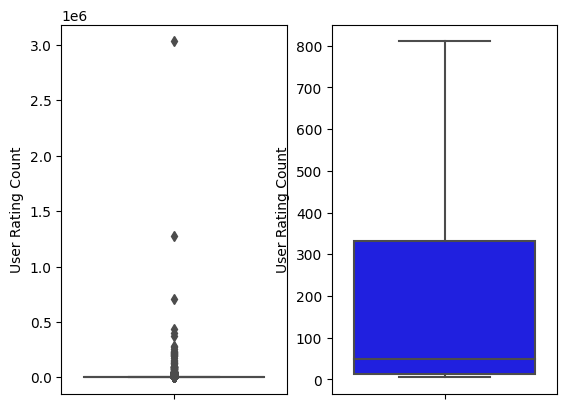

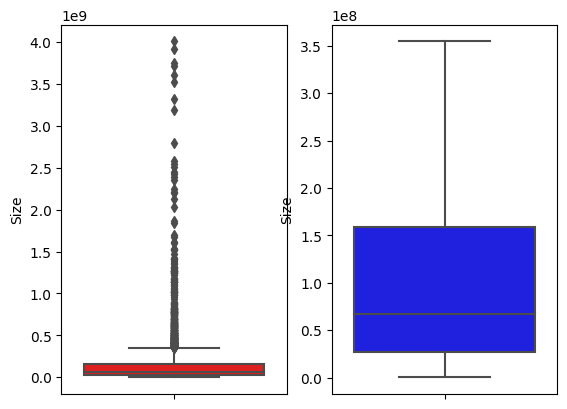

In [88]:
outliarlist=["User Rating Count","Size"]
for i in outliarlist:
    outliers(df,i)

<br>

## `6. Apply One Hot Encoding On Categories`

In [89]:
# replace tst with df
df = PreprocessListCategories(df,['Primary Genre', 'Genres', 'Languages'])

In [90]:
df.shape

(5160, 188)

In [91]:
df = feature_transformation(df)

In [92]:
df.head()

,Country,ID,Name,Color,User Rating Count,Price,In-app Purchases,Description,Other by developer,Age Rating,...,TT,UG,UK,UR,UZ,VI,YI,ZH,ZU,Years Since Release
0,us,1264483706,HEIR OF LIGHT,is3,1.000000,0,19.24,"A Dark Fantasy, Collectible RPG\n\nDarkness ha...",2,3,...,0,0,0,0,0,1,0,1,0,2
1,us,607705356,Endgame:Eurasia,is4,0.017381,0,0.00,"""This interactive experience is an exploration...",2,3,...,0,0,0,0,0,0,0,0,0,5
2,us,627491527,Free Solitaire+,is5,0.011173,0,0.00,Same Solitaire game with classic Solitaire run...,3,1,...,0,0,0,0,0,0,0,1,0,3
3,us,430252596,Draft Trainer,is1,0.103042,1,0.00,** Discounted for a limited time **\n\nEver wo...,1,2,...,0,0,0,0,0,0,0,0,0,9
4,us,1115082819,Rogue Knight: Infested Lands,is2,0.009932,1,0.00,Fight or sneak your way through hordes of mons...,1,3,...,0,0,0,0,0,0,0,0,0,3
